In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from torch.optim import AdamW

#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import collections
from collections import defaultdict, Counter
#import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from transformers import pipeline

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import classification_report

import time

import os


### BERT_Hierarchical

The code is to fine-tune BERT by computing the pooled result from the output of each segment of the long document.
It first uses BertTokenizer to encode the document, 
then get the encoding of the first 512 tokens and also the overflowing tokens if the document has more than the defined max length tokens.
Based on the encoding of the first 512 tokens and the overflowing tokens (ids), we can get the encoding of the whole document and then segment
the encoding with overlapping tokens. The encoding of each segment is then as input to the Bert model.
For each segment we will get an output and then do pooling.

The code is debugged step by step and some comments are added with small examples.

The main code is extracted from https://github.com/helmy-elrais/RoBERT_Recurrence_over_BERT.


### Data Preparing

get the 20newsgroups dataset and then split into training set (90%) and validation set(10%)

In [36]:
categories = [ "alt.atheism", "talk.religion.misc", "comp.graphics",]

remove = ("headers", "footers", "quotes")

newsgroups = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, 
                                        random_state=238, remove=remove)
# val_ng = fetch_20newsgroups(subset='test',  categories=categories, shuffle=True, 
#                                        random_state=42, remove=remove)

# newsgroups = fetch_20newsgroups(subset='train', shuffle=True, 
#                                       random_state=238, remove=remove)
# test_ng = fetch_20newsgroups(subset='test', shuffle=True, 
#                                       random_state=238, remove=remove)

data_train, data_val, label_train, label_val = train_test_split(newsgroups.data, newsgroups.target, test_size=0.1, random_state=42)
train_ng = {'data': data_train, 'target': label_train}
val_ng = {'data': data_val, 'target': label_val}

print("data loaded")

# print('size of training set:', len(train_ng.data))
# print('size of validation set:', len(val_ng.data))
# print('classes:', train_ng.target_names)
print('size of training set:', len(data_train))
print('size of validation set:', len(data_val))
print('classes:', newsgroups.target_names)

# data_train = train_ng.data
# label_train = train_ng.target
# data_test = test_ng.data
# label_test = test_ng.target

data loaded
size of training set: 10182
size of validation set: 1132
classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


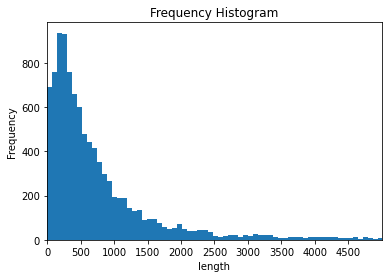

In [38]:
#length = [len(l) for l in train_ng.data]
length = [len(l) for l in train_ng['data']]
plt.hist(length, bins=1000)
plt.title("Frequency Histogram")
plt.xlabel("length")
plt.ylabel("Frequency")
plt.xlim((0, 5000))
plt.xticks(np.arange(0, 5000, step=500))
plt.show()

In [39]:
print('Initializing BertTokenizer')

BERTMODEL='bert-base-uncased'
CACHE_DIR='transformers-cache'

tokenizer = BertTokenizer.from_pretrained(BERTMODEL, cache_dir=CACHE_DIR,
                                          do_lower_case=True)

Initializing BertTokenizer


In [6]:
if torch.cuda.is_available():    
    device = torch.device("cuda:2") # specify  devicethe
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [41]:
# get the input_ids_list, attention_mask_list of the long document. Each element in the list correspondes to a segment.
# also get target for each segment and the number of segments.
class LongNewsDataset(torch.utils.data.Dataset):
    def __init__(self, docs, targets, tokenizer, max_len, chunk_len=512, overlap_len=50):
        self.docs = docs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.overlap_len = overlap_len
        self.chunk_len = chunk_len

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, item):
        doc = str(self.docs[item])
        target = int(self.targets[item])
        
        # get the encoding of the first 512 tokens and the overflowing tokens if the document has more than the defined max length tokens
        encoding = self.tokenizer.encode_plus(
          doc,
          add_special_tokens=True,
          max_length=self.chunk_len,
          truncation=True,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_overflowing_tokens=True,
          return_tensors='pt',
        )

        long_token = self.long_terms_tokenizer(encoding, target)

        return long_token

    def long_terms_tokenizer(self, data_tokenize, target):
        long_terms_token = []
        input_ids_list = []
        attention_mask_list = []
        target_list = []
        
        # get the input_ids and attention mask of the first 512 tokens
        previous_input_ids = data_tokenize["input_ids"].reshape(-1)
        previous_attention_mask = data_tokenize["attention_mask"].reshape(-1)
        # get the input_ids of overflowing tokens
        remain = data_tokenize['overflowing_tokens'].flatten()
        target = torch.tensor(target, dtype=torch.int)

        input_ids_list.append(previous_input_ids)
        attention_mask_list.append(previous_attention_mask)
        target_list.append(target)
        
        # segment the input_ids with overlapping
        # some tricks are used here to segment with overlapping
        if remain.shape[0] != 0:
            idxs = range(len(remain)+self.chunk_len)
            idxs = idxs[(self.chunk_len-self.overlap_len-2)::(self.chunk_len-self.overlap_len-2)]
            input_ids_first_overlap = previous_input_ids[-(self.overlap_len+1):-1]
            start_token = torch.tensor([101], dtype=torch.long)
            end_token = torch.tensor([102], dtype=torch.long)

            for i, idx in enumerate(idxs):
                if i == 0:
                    input_ids = torch.cat(
                        (input_ids_first_overlap, remain[:idx]))
                elif i == len(idxs):
                    input_ids = remain[idx:]
                elif previous_idx >= len(remain):
                    break
                else:
                    input_ids = remain[(previous_idx-self.overlap_len):idx]

                previous_idx = idx

                nb_token = len(input_ids)+2
                attention_mask = torch.ones(self.chunk_len, dtype=torch.long)
                attention_mask[nb_token:self.chunk_len] = 0
                input_ids = torch.cat((start_token, input_ids, end_token))

                if self.chunk_len-nb_token > 0:
                    padding = torch.zeros(
                        self.chunk_len-nb_token, dtype=torch.long)
                    input_ids = torch.cat((input_ids, padding))

                input_ids_list.append(input_ids)
                attention_mask_list.append(attention_mask)
                target_list.append(target)

        return({
            # input_ids_list [tensor seg1, tensor seg2, tensor seg3, ...]
            # torch.tensor(ids, dtype=torch.long)
            'input_ids': input_ids_list,  
            'attention_mask': attention_mask_list,
            # [tensor seg1, tensor seg2, tensor seg3,...]
            'targets': target_list,
            'len': [torch.tensor(len(target_list), dtype=torch.long)]
        })

In [42]:
def my_collate1(batches):
    # return batches
    # avoid shape error
    return [{key: torch.stack(value) for key, value in batch.items()} for batch in batches]

In [43]:
def create_data_loader(newsgroups, tokenizer, max_len, batch_size):
    ds = LongNewsDataset(
        docs=newsgroups['data'],
        #docs=newsgroups.data,
        targets=newsgroups['target'],
        #targets=newsgroups.target,
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        collate_fn=my_collate1
      )

In [44]:
BATCH_SIZE = 16
#BATCH_SIZE = 4
MAX_LEN = 512

train_data_loader = create_data_loader(train_ng, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_ng, tokenizer, MAX_LEN, BATCH_SIZE)

In [45]:
class BERT_Hierarchical_Model(nn.Module):
    def __init__(self, n_classes, pooling_method="mean"):
        super(BERT_Hierarchical_Model, self).__init__()
        self.pooling_method = pooling_method
        self.bert = BertModel.from_pretrained(BERTMODEL) #bert model from huggingface
        self.drop = nn.Dropout(p=0.3) # add dropout of 0.3 on top of bert output
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # Linear layer as a classifier
    
    def forward(self, input_ids, attention_mask, lengt):
        
        # for example, when batch_size=4, four document, doc 1, doc 2, doc 4 are less than 512 tokens, doc 3 about 4*512 tokens
        # input_ids:  tensor([[ doc 1], [doc 2], [doc 3 seg 1], [ doc 3 seg 2], [doc 3 seg 3], [doc 3 seg 4], [doc 4]])
        
        # pooled output: CLS token 
        # pooled_output shape: (number of segments of all documents in one batch * 786)
        # In this small example, 7 * 786
        # here not batch_size * 786 because of segmentation of long document
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        
        # split according to the number of segments 
        # then know which document the pooled_output belongs to 
        # chunks_emb (tensor([[doc1]]), tensor([[doc2]]), tensor([[doc3 seg1], [doc3 seg2], [doc3 seg3], [doc4 seg4]]), tensor([[doc4]])
        chunks_emb = pooled_output.split_with_sizes(lengt) 
        
        if self.pooling_method == "mean":
            emb_pool = torch.stack([torch.mean(x, dim=0) for x in chunks_emb]) 
        elif self.pooling_method == "max":
            # torch.max return (value, indice)
            # here [0] to get the value
            emb_pool = torch.stack([torch.max(x, dim=0)[0] for x in chunks_emb])
        
        output = self.out(self.drop(emb_pool))
        #output = self.out(emb_pool)
        return F.softmax(output, dim=1)

In [47]:
model = BERT_Hierarchical_Model(len(train_ng['target']))
#model =  BERT_Hierarchical_Model(len(train_ng.target_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# Hyperparameters
EPOCHS = 10
#EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    t0 = time.time()

    for batch_idx, batch in enumerate(data_loader):
        
        # for example, when batch_size=4, four document, doc 1, doc 2, doc 4 are less than 512 tokens, doc 3 about 4*512 tokens
        # the input_ids would be:
        # [tensor([[doc1 input_ids]]),tensor([[doc2 segment1 input_ids], [doc2 seg2], [doc2 seg3],[doc2 seg4]]), tensor([[doc3]]), tensor([[doc4]])]
        input_ids = [data["input_ids"] for data in batch]
        # similar to input_ids
        attention_mask = [data["attention_mask"] for data in batch]
        # [tensor(target), tensor(target), tensor(target), tensor(target)]  
        # here [0] to reduce the dimension
        targets = [data["targets"][0] for data in batch]
        # get the number of segments for each document 
        # [tensor([1]), tensor([1]), tensor([4]), tensor([1])]
        lengt = [data['len'] for data in batch]
        
        # change the shape as input to Bert Model
        # tensor([[ doc 1], [doc 2], [doc 3 seg 1], [ doc 3 seg 2], [doc 3 seg 3], [doc 3 seg 4], [doc 4]])
        input_ids = torch.cat(input_ids)
        attention_mask = torch.cat(attention_mask)
        # tensor([doc1 target, doc2 target, doc3 target, doc4 target], dtype=torch.int32)
        targets = torch.stack(targets)
        # [doc1 num of segments, doc2 num of segments,... ]
        # [1, 1, 4, 1]
        lengt = [x.item() for x in lengt]
        
        input_ids = input_ids.to(device, dtype=torch.long)
        attention_mask = attention_mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.long)
        optimizer.zero_grad()
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          lengt=lengt
        )
        
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(float(loss.item()))
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  
        
        torch.cuda.empty_cache()
    
    print(f"time = {time.time()-t0:.2f} secondes")
    t0 = time.time()
        
    return np.mean(losses), float(correct_predictions / n_examples)

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):

            input_ids = [data["input_ids"] for data in batch]
            attention_mask = [data["attention_mask"] for data in batch]
            targets = [data["targets"][0] for data in batch]
            lengt = [data['len'] for data in batch]

            input_ids = torch.cat(input_ids)
            attention_mask = torch.cat(attention_mask)
            targets = torch.stack(targets)
            lengt = [x.item() for x in lengt]

            input_ids = input_ids.to(device, dtype=torch.long)
            attention_mask = attention_mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
              lengt=lengt
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(float(loss.item()))

    return np.mean(losses), float(correct_predictions / n_examples)

In [34]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model,
                                        train_data_loader,    
                                        loss_fn, 
                                        optimizer, 
                                        device, 
                                        scheduler, 
                                        len(train_ng['data'])
                                        #len(train_ng.data)
                                        )

    
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_loss, val_acc = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_ng['data'])
    #len(val_ng.data)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    print(history)
    
    #if val_acc > best_accuracy:
        #torch.save(model.state_dict(), 'best_model_state.bin')
        #best_accuracy = val_acc

Epoch 1/2
----------


KeyboardInterrupt: 

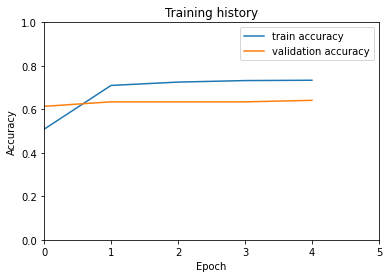

In [61]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.xlim([0, 5])
plt.ylim([0, 1])
plt.savefig('BERT_Hierarchical_Model.png')